In [21]:
import cvxpy as cp
import numpy as np
import dccp
import numpy.typing as npt
from enum import Enum
from multireward_ope.tabular.mdp import MDP
from multireward_ope.tabular.characteristic_time import CharacteristicTimeSolver
from multireward_ope.tabular.reward_set import RewardSetCircle, \
    RewardSetRewardFree, RewardSetPolytope
from typing import NamedTuple
from multireward_ope.tabular.envs.riverswim import RiverSwim, RiverSwimParameters
from multireward_ope.tabular.policy import Policy, PolicyFactory
import matplotlib.pyplot as plt


mdp = RiverSwim(RiverSwimParameters(5))
policy = PolicyFactory.from_sequence(np.ones(mdp.dim_state, dtype=np.long))
gamma = 0.9

rfree = RewardSetRewardFree(mdp.dim_state, mdp.dim_action, RewardSetRewardFree.RewardSetFreeConfig())
solver = CharacteristicTimeSolver(mdp.dim_state, mdp.dim_action, solver=cp.GUROBI)
solver.build_problem(rfree)


reward = cp.Variable(mdp.dim_state, nonneg=True)
lambdavar = cp.Variable(nonneg=True)
constraints = [reward <=lambdavar, lambdavar <=1-1e-9, lambdavar >=0]
K = []
G = mdp.build_stationary_matrix(policy, gamma=gamma)
for s in range(mdp.dim_state):
    e_s = np.zeros(mdp.dim_state)
    e_s[s] = 1
    
    K_s = (e_s - mdp.P[s,policy[s]]) @G @ reward

    K.append(cp.abs(K_s))

K = cp.vstack(K)
K = cp.max(K)

obj = cp.Minimize(K)
problem = cp.Problem(obj, constraints)
res = problem.solve()

print(res)
print(reward.value)


        


1.0408340855860843e-16
[0.1892535 0.1892535 0.1892535 0.1892535 0.1892535]


Text(0, 0.5, 'Characteristic time $T^\\star$')

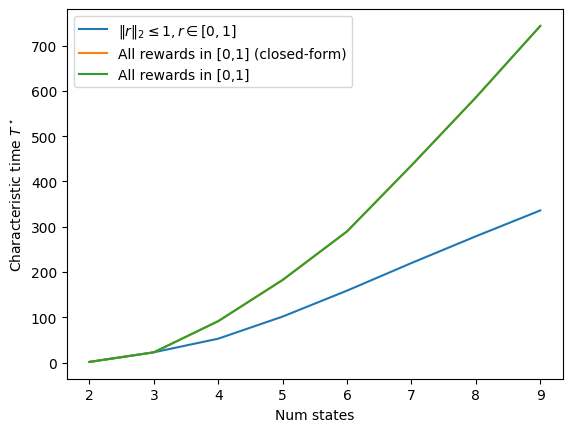

In [2]:
from multireward_ope.tabular.envs.riverswim import RiverSwim, RiverSwimParameters
from multireward_ope.tabular.policy import Policy, PolicyFactory
import matplotlib.pyplot as plt


results_circle = []
results_rfree = []
results_box = []
np.random.seed(0)
for s in range(2, 10):
    mdp = RiverSwim(RiverSwimParameters(s))
    policy = PolicyFactory.from_sequence(np.ones(mdp.dim_state, dtype=np.long))
    rewards = RewardSetCircle(mdp.dim_state, mdp.dim_action,
        RewardSetCircle.RewardSetCircleConfig(np.zeros(mdp.dim_state), radius=1, p=2))
    rbox = RewardSetPolytope.from_box(mdp.dim_state, mdp.dim_action,
         a=np.zeros(mdp.dim_state), b=np.ones(mdp.dim_state))
    rfree = RewardSetRewardFree(mdp.dim_state, mdp.dim_action, RewardSetRewardFree.RewardSetFreeConfig())
    solver = CharacteristicTimeSolver(mdp.dim_state, mdp.dim_action,solver=cp.GUROBI)
    solver.build_problem(rewards)
    results_circle.append(solver.solve(0.9, mdp, policy).value)

    solver.build_problem(rfree)
    solution = solver.solve(0.9, mdp, policy)
    # print(solution.w / solution.w.sum(-1, keepdims=True))
    results_rfree.append(solution.value)

    solver.build_problem(rbox)
    results_box.append(solver.solve(0.9, mdp, policy).value)
plt.plot(range(2,10), results_circle, label='$\|r\|_2 \leq 1, r\in [0,1]$')
plt.plot(range(2,10), results_rfree, label='All rewards in [0,1] (closed-form)')
plt.plot(range(2,10), results_box, label='All rewards in [0,1]')
plt.legend()
plt.xlabel('Num states')
plt.ylabel('Characteristic time $T^\star$')